# **Báo cáo Case Study: News Headlines Dataset For Sarcasm Detection.**  
****

## **Nhóm:**

| Họ Và Tên  | MSSV  |
| ------ | ----- |
| Trần Đình Khang | 18520072|
| Vũ Quí San | 18520143 |

##  **Mô tả bài toán:**

Việc phát hiện tin giả để loại bỏ tin giả đó khỏi mạng xã hội hay các tờ báo là một việc rất quan trọng bởi tin giả có thể gây ra nhận thức sai lầm cho người dân, gây thiệt hại, làm mất uy tín các cá nhân, tổ chức hay thậm chí gây ảnh hưởng đến an ninh trật tự xã hội. Một vấn đề gây khó khăn trong việc xây dựng hệ thống nhận biết tin giả chính là sự nhầm lẫn giữa tin giả và tin mang tính chất châm biếm hay mỉa mai. Tin châm biếm hay mỉa mai là tin thật nhưng lại thường được diễn đạt không tường minh, nghĩa đen có thể rất giống tin giả. Vì vậy, bài toán xây dựng hệ thống phân loại tin có châm biếm (hay mỉa mai) hay không là một trong những bài toán tiền đề để giải bài toán phân loại tin giả tin thật.  

Cụ thể hơn, ta xét bài toán phát hiện tiêu đề bài báo có nội dung châm biếm (*News Headlines dataset for Sarcasm Detection*) từ [Kaggle](https://www.kaggle.com/rmisra/news-headlines-dataset-for-sarcasm-detection). Dataset được thu thập từ hai tờ báo, thứ nhất là tờ [*TheOnion*](https://www.theonion.com/) (chỉ lấy từ mục News in Brief và mục News in Photos) gồm toàn bài có tiêu đề châm biếm, thứ hai là tờ [*HuffPost*](https://www.huffpost.com/) không có bài nào có tiêu đề châm biếm.
* Input: Tiêu đề bài báo.
* Ouput: Tiêu đề bài báo được phân lớp là 1 nếu mang tính châm biếm, ngược lại được phân lớp là 0.

**Về dữ liệu:**
* Dữ liệu huấn luyện: Dữ liệu được download trên trang [Kaggle](https://www.kaggle.com/rmisra/news-headlines-dataset-for-sarcasm-detection) được lưu trong file json. Mỗi dòng dữ liệu bao gồm: 
     * **article**: Link dẫn tới bài báo.
     * **headline**: Tiêu đề của bài báo cần phân loại.
     * **is sarcasm**: Tiêu đề có phải là châm biếm hay không. Nếu có mang giá trị 1, ngược lại là 0.
      
* Dữ liệu kiểm thử: Crawl trên 2 trang báo điện tử ở trên. Tổng cộng có 2000 tiêu đề mới.

## **0. Kết nối với Google Drive và chuyển đường dẫn:**


In [1]:
# Connect with ggdrive
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
# Go to path 
%cd '/content/drive/My Drive/Colab Notebooks/[Case Study] News Headlines Dataset For Sarcasm Detection'

/content/drive/My Drive/Colab Notebooks/[Case Study] News Headlines Dataset For Sarcasm Detection


## **1. Khai báo thư viện:**


In [3]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


##**2. Thu thập và tải dữ liệu:**

- Đối với dữ liệu Train thì được lấy từ [Kaggle](https://www.kaggle.com/) với 2 file json là **Sarcasm_Headlines_Dataset.json** và **Sarcasm_Headlines_Dataset_v2.json**
- Còn đối với dữ liệu Test thì được crawl từ hai trang là [TheOnion](https://www.theonion.com/) và [HuffPost](https://www.huffpost.com/) , trong đó dữ liệu từ [TheOnion](https://www.theonion.com/) được lưu trong file **onion_headlines.csv**
còn dữ liệu từ [HuffPost](https://www.huffpost.com/) được lưu trong file **huffpost_headlines.csv**.




### **2.1 Thu thập dữ liệu:**

####**2.1.1 Dữ liệu mới từ TheOnion:**

Đối với trang TheOnion thì mỗi lần ta bấm vào nút “More stories” thì ta sẽ được chuyển đến trang mới gồm 20 bài báo tiếp theo, đường link của các trang chỉ khác nhau ở dãy số cuối nên ta có thể copy các dãy số này bằng tay và lưu vào trong các list. Cụ thể, list đầu tiên là brief_ids lưu các dãy số, mỗi dãy số ứng với một trang gồm 20 bài báo thuộc mục News in Brief; tương tự vậy, list thứ hai là photo_ids lưu các dãy số của các trang chứa bài báo trong mục News in Photos:

In [4]:
import requests
from datetime import datetime
from bs4 import BeautifulSoup
import csv

brief_ids = [1592311200653, 1591726080182, 1591127280478, 1590584520209, 
             1589894280339, 1589294340828, 1588711020164, 1588080060229, 
             1587147720532, 1586546460312, 1586184540217, 1585581600531,
             1582920840434, 1582639200695, 1582128720515, 1581532200479,
             1581099360048, 1580744340055, 1580142900840, 1579637820343,
             1579096620327, 1578410280620, 1576700820848, 1576184280994,
             1575574260415, 1575036000486, 1574361720213, 1573762560848,
             1573477200438, 1572900480129, 1572348600499, 1571938620032,
             1571419440061]

photo_ids = [1590159060816, 1588708260098, 1587653040878, 1585925400900,
             1584127800188, 1582815000473, 1582061760395, 1580835900882,
             1579528800910, 1576610760393, 1574702400578, 1573153500106,
             1571849700244, 1570194000584, 1569247200599, 1567182180912,
             1565892720386, 1564614900603, 1563235200067, 1560963960321,
             1559133180370, 1557413700296, 1556108520577, 1554495180638,
             1552834800968, 1551123540512, 1550160960071, 1548972300054,
             1547739780965, 1544713860139, 1543513440446, 1541701980758,
             1539720900721]



Duyệt từng trang, tại mỗi trang tìm tất cả các bài báo (tương ứng với việc tìm các tag article), tại mỗi bài báo thì tìm tiêu đề của bài báo đó (nghĩa là tìm tag h2):

In [5]:
def Onion_crawler(tag, ids, num_articles, label=1):
  count = 0
  for id in ids:
    source = requests.get("https://www.theonion.com/c/{}?startTime={}".format(tag,id)).text
    soup = BeautifulSoup(source, 'lxml')
    for article in soup.find_all('article'):
      headline = article.h2.text
      csv_writer.writerow([label, headline])
      count += 1
      if count == num_articles:
        print(f"Crawled {count} headlines from {tag} tag")
        return

Lưu dữ liệu crawl được vào  file **onion_headlines.csv**:

In [6]:
csv_file = open('./data_sarcasm/Test/onion_headlines.csv', 'w')
csv_writer = csv.writer(csv_file)
csv_writer.writerow(['is_sarcastic', 'headline'])

Onion_crawler("news-in-brief", brief_ids, num_articles=644, label=1)
Onion_crawler("news-in-photos", photo_ids, num_articles=643, label=1)
csv_file.close()

Crawled 644 headlines from news-in-brief tag
Crawled 643 headlines from news-in-photos tag


####**2.1.2 Dữ liệu mới từ HuffPost:**


*  Ta lấy data từ API của HuffPost:
    * Đầu tiên gửi request lấy [500 bài báo đầu tiên](https://www.huffpost.com/api/department/news/cards?page=1&limit=500) từ API. Tại đây ta copy toàn bộ file json và lưu vào file **huffpost_part1.json**.
    * Tiếp theo ta gửi request lấy [500 bài báo tiếp theo](https://www.huffpost.com/api/department/news/cards?page=2&limit=500) từ API. Tuy nhiên lần này API chỉ trả về 213 bài báo. Như vậy HuffPost API chỉ cho ta request 713 bài báo gần đây. Ta copy file json và lưu vào file **huffpost_part2.json**.
*  Sau khi đã chuẩn bị xong 2 file json. Ta tiến hành đọc 2 file này. Dữ liệu đọc từ file json được lưu dưới dạng các dict và list lồng nhau của Python nên ta có thể dễ dàng dùng index (đối với list) và key (đối với dict) để truy cập vào miền chứa headline. Ta lưu các headline thu được vào file **huffpost_headlines.csv**

In [7]:
import json

In [8]:
with open('./data_sarcasm/Test/huffpost_part1.json') as f:
    part1 = json.load(f)

with open('./data_sarcasm/Test/huffpost_part2.json') as f:
    part2 = json.load(f)

csv_file = open('./data_sarcasm/Test/huffpost_headlines.csv', 'w')
csv_writer = csv.writer(csv_file)
csv_writer.writerow(['is_sarcastic', 'headline'])

for article in part1["cards"]:
  headline = article["headlines"][0]["text"]
  csv_writer.writerow([0, headline])
    
for article in part2["cards"]:
  headline = article["headlines"][0]["text"]
  csv_writer.writerow([0, headline])

csv_file.close()

### **2.2 Tải dữ liệu:**

#### **2.2.1 Tải dữ liệu Train:**


* Ta có hai file **Sarcasm_Headlines_Dataset.json** và **Sarcasm_Headlines_Dataset_v2.json** , bây giờ ta kết hợp 2 file lại cho vào cùng một DataFrame **df_Train**.
* Sau đó bỏ đi các hàng trùng nhau.



In [9]:
df1 = pd.read_json('./data_sarcasm/Train/Sarcasm_Headlines_Dataset_v2.json',lines=True)
df2 = pd.read_json('./data_sarcasm/Train/Sarcasm_Headlines_Dataset.json',lines=True)

# join two dataframe
df_Train = pd.concat([df1,df2],ignore_index=True)

# Drop duplicate rows in dataframe
df_Train.drop_duplicates(ignore_index=True)

# View top df_Train
df_Train.head()

,is_sarcastic,headline,article_link
0,1,thirtysomething scientists unveil doomsday clo...,https://www.theonion.com/thirtysomething-scien...
1,0,dem rep. totally nails why congress is falling...,https://www.huffingtonpost.com/entry/donna-edw...
2,0,eat your veggies: 9 deliciously different recipes,https://www.huffingtonpost.com/entry/eat-your-...
3,1,inclement weather prevents liar from getting t...,https://local.theonion.com/inclement-weather-p...
4,1,mother comes pretty close to using word 'strea...,https://www.theonion.com/mother-comes-pretty-c...


In [10]:
# Assigning
X_train_pre = df_Train['headline']
y_train = df_Train['is_sarcastic'].to_numpy()

#### **2.2.2 Tải dữ liệu Test:**


* Lấy dữ liệu từ 2 file **onion_headlines.csv** và **huffpost_headlines.csv**, sau đó bỏ vào cùng DataFrame **df_Test**.




In [11]:
# Load 
huffpost_df = pd.read_csv('./data_sarcasm/Test/huffpost_headlines.csv')

# Load
onion_df = pd.read_csv('./data_sarcasm/Test/onion_headlines.csv')

# Join two dataframe
df_Test = pd.concat([huffpost_df,onion_df],ignore_index=True)

# Drop duplicate row
df_Test.drop_duplicates(ignore_index=True)

# View top df_Test
df_Test.head()

,is_sarcastic,headline
0,0,2 Lawyers Of Color Face 45-Year Sentences — Fo...
1,0,Tulsa Rally Failure May Spark Trump Campaign T...
2,0,Coronavirus Live Updates: COVID-19 Cases Near ...
3,0,Trump Baselessly Claims 2020 Election Is 'RIGG...
4,0,Size Matters: Never-Trump GOP Group Dumps On P...


In [12]:
# Assigning
X_test_pre = df_Test['headline']
y_test = df_Test['is_sarcastic'].to_numpy()


##**3. Trực quan hóa dữ liệu và Tiền xử lý dữ liệu:**

###**3.1 Trực quan hóa dữ liệu:**


* Theo hình thu được thì tập **Training set** có số lượng **is_sarcasm = 1** gần bằng số lượng **is_sarcasm = 0**, cho nên tạo thuận lợi cho việc train dữ liệu.
* Đối với **Test Set** thì có sự chênh lệch khá nhiều giữa **is_sarcasm = 1** và **is_sarcasm = 0**.


Text(0.5, 1.0, 'Test Set')

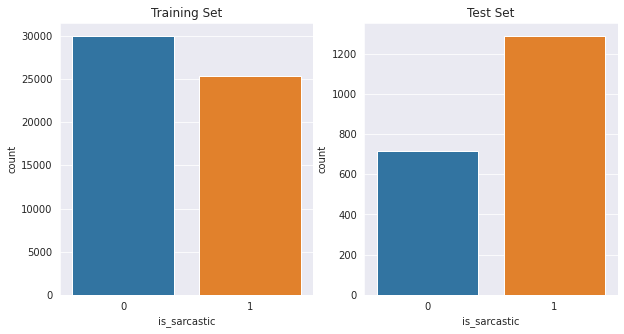

In [13]:
%matplotlib inline
sns.set_style("darkgrid")
fig, axes = plt.subplots(1,2,figsize=(10,5))
sns.countplot(df_Train.is_sarcastic,ax=axes[0]).set_title('Training Set')
sns.countplot(df_Test.is_sarcastic,ax=axes[1]).set_title('Test Set')

###**3.2 Tiền xử lí dữ liệu:**


####**3.2.1 Kiểm tra có giá trị NaN?**

In [14]:
# checking for df_Train
df_Train.isna().sum() # -> no Nan value

is_sarcastic    0
headline        0
article_link    0
dtype: int64

In [15]:
# checking for df_Test
df_Test.isna().sum() # -> no Nan value

is_sarcastic    0
headline        0
dtype: int64

####**3.2.2 Làm sạch dữ liệu:**

 *  Vì dữ liệu là text nên có các kí tự đặc biệt nên cần được phân tách và loại bỏ. 


In [16]:
import re,string
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer 

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [17]:
stopw = set(stopwords.words('english'))
punctuation = list(string.punctuation)
stopw.update(punctuation)

* **Một số hàm để xử lý dữ liệu text:**


In [18]:
#Removing the header html
def strip_html(text):
    soup = BeautifulSoup(text, "html.parser")
    return soup.get_text()

In [19]:
#Removing the square brackets
def remove_between_square_brackets(text):
    return re.sub("\[[^]]*\]", '', text)

In [20]:
# Removing URL's
def remove_URL(text):
    return re.sub(r'http\S+', '', text)

In [21]:
#Removing the stopwords from text
def remove_stopwords(text):
    final_text = []
    word_list = word_tokenize(text)
    for txt in word_list:
        if txt.strip().lower() not in stopw:
            final_text.append(txt.strip())
    return " ".join(final_text)


In [22]:
#Removing the punctuation
def remove_punctuation(text):
    symbols = '!\"#$%&()*+-./:;<=>?@[\]^_`{|}~\n'
    word_list = word_tokenize(text)
    final_text = []
    for word in word_list:
        for w in word:
            if w in symbols:
                word = word.replace(w," ")
        word = word.strip()
        if len(word) > 0:
            final_text.append(word)
    return ' '.join(final_text)

In [23]:
#Removing Single Characters
def remove_single_characters(text):
    final_text = []
    word_list = word_tokenize(text)
    for word in word_list:
        if len(word) > 1 or word.isdigit():
            final_text.append(word)
    return ' '.join(final_text)

In [24]:
# removing Apostrophe
def remove_apostrophe(text):
    return re.sub("'",'',text)


In [25]:
# Lemmatisation
def Lemmatisation(text):
    lemmatizer = WordNetLemmatizer()
    word_list = word_tokenize(text)
    return ' '.join([lemmatizer.lemmatize(w) for w in word_list])

In [26]:
# clean data
def clean_data(text):
    text = text.lower().strip()
    text = strip_html(text)
    text = remove_URL(text)
    text = remove_between_square_brackets(text)
    text = remove_punctuation(text)
    text = remove_apostrophe(text)
    text = remove_single_characters(text)
    text = remove_stopwords(text)
    text = Lemmatisation(text)
    text = remove_single_characters(text)
    return text

* **Áp dụng hàm clean data để làm sạch dữ liệu:**


In [27]:
# Apply for X_train_pre
X_train_pre = X_train_pre.apply(clean_data)
# Apply for X_test
X_test_pre = X_test_pre.apply(clean_data)

* **Test thử 10 dữ liệu đầu tiên có được làm sạch theo đúng chuẩn hay không?**


In [28]:
print('X_train:')
for i in range(10):
    print('- loop {}-th\n{}\n{}\n'.format(i,df_Train['headline'].loc[i],X_train_pre.loc[i]))

X_train:
- loop 0-th
thirtysomething scientists unveil doomsday clock of hair loss
thirtysomething scientist unveil doomsday clock hair loss

- loop 1-th
dem rep. totally nails why congress is falling short on gender, racial equality
dem rep totally nail congress falling short gender racial equality

- loop 2-th
eat your veggies: 9 deliciously different recipes
eat veggie 9 deliciously different recipe

- loop 3-th
inclement weather prevents liar from getting to work
inclement weather prevents liar getting work

- loop 4-th
mother comes pretty close to using word 'streaming' correctly
mother come pretty close using word streaming correctly

- loop 5-th
my white inheritance
white inheritance

- loop 6-th
5 ways to file your taxes with less stress
5 way file tax le stress

- loop 7-th
richard branson's global-warming donation nearly as much as cost of failed balloon trips
richard branson global warming donation nearly much cost failed balloon trip

- loop 8-th
shadow government getting t

##**4. Feature engineering cho bộ dữ liệu:**

In [29]:
from sklearn.feature_extraction.text import TfidfVectorizer

Tvec_train = TfidfVectorizer(ngram_range=(1,2),max_features=80000)

# transform words to vetor
X_train = Tvec_train.fit_transform(X_train_pre.values)

Tvec_test = TfidfVectorizer(vocabulary=Tvec_train.vocabulary_,ngram_range=(1,2),max_features=80000)
X_test = Tvec_test.fit_transform(X_test_pre.values)

##**5. Huấn luyện và thử nghiệm  mô hình:**

#### **5.1 StratifiedKFold Cross Validation:**



#### **5.2 Thử nghiệm các mô hình khác nhau:**

**Các mô hình thử nghiệm:**
*  **LogisticRegression**
*  **Linear SVM**
*  **KNeighbors  Classifier** 
*  **DecisionTree Classifier**

In [30]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.neighbors import KNeighborsClassifier

In [31]:
models = []
models.append(LogisticRegression(solver='liblinear', multi_class='ovr'))
models.append(LinearSVC())
models.append(KNeighborsClassifier())
models.append(DecisionTreeClassifier())

In [32]:
# evaluate each model in turn
results = [[] for _ in range(len(models))]
names = ['' for _ in range(len(models))]

skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=1)
for train_idx, val_idx in skf.split(X_train_pre,y_train):
	X_train_fold, X_val_fold = X_train_pre[train_idx], X_train_pre[val_idx]
	y_train_fold, y_val_fold = y_train[train_idx], y_train[val_idx]
	
	Tvec1 = TfidfVectorizer(ngram_range=(1,2),max_features=80000)
	# transform words to vetor
	X_train_fold = Tvec1.fit_transform(X_train_fold)
	
	Tvec2 = TfidfVectorizer(vocabulary=Tvec1.vocabulary_,ngram_range=(1,2),max_features=80000)
	X_val_fold = Tvec2.fit_transform(X_val_fold)
	for i in range(len(models)):
		model = models[i]
		model.fit(X_train_fold, y_train_fold)
		y_pred = model.predict(X_val_fold)
		score = accuracy_score(y_val_fold, y_pred)
		results[i].append(score)
		names[i] = model.__class__.__name__


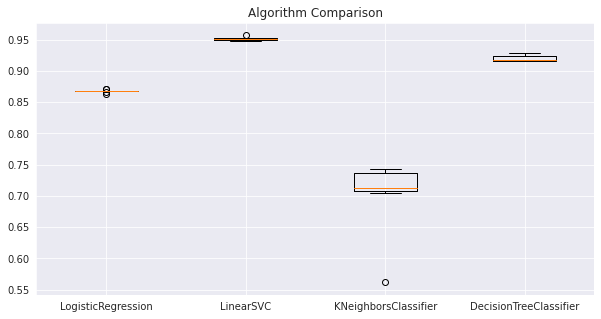

In [33]:
plt.figure(figsize=(10,5))
plt.boxplot(results,labels=names)
plt.title('Algorithm Comparison')
plt.show()

In [34]:
results_mean = np.array(results).mean(axis=1)

In [35]:
for i in range(len(models)):
    print('{}: {}'.format(models[i].__class__.__name__,results_mean[i]))

LogisticRegression: 0.8675896994291401
LinearSVC: 0.951579708627875
KNeighborsClassifier: 0.7059717518199813
DecisionTreeClassifier: 0.9205827416360315


**Chọn model LinearSVM vì có score 0.951 cao nhất**




## **6. Dự đoán đoạn text:**


In [36]:
def predict_text(text):
    text = clean_data(text)
    Tvec_text = TfidfVectorizer(vocabulary=Tvec_train.vocabulary_,ngram_range=(1,2),max_features=80000)
    X_text = Tvec_text.fit_transform([text])
    lsvc = LinearSVC()
    lsvc.fit(X_train,y_train)
    return 'is sarcasm' if lsvc.predict(X_text) == 1 else 'not sarcasm'


In [37]:
text = input()
print(predict_text(text))

khang tran
not sarcasm


## **7. Dự đoán kết quả với tập test:**


In [38]:
# Using linear support vector classifier
best_model = LinearSVC()
# training the model
best_model.fit(X_train,y_train)
# getting the score of train and test data
print(best_model.score(X_test, y_test))   

0.7955


**Score trên tập train rất cao 0.951 nhưng khi thêm dự đoán trên tập Test thì chỉ còn 0.7955. Giảm Score như vậy có thể là do tập Test chứa những word mà tập Train không có, có thể xử lí tách câu, ngữ nghĩa của từ chưa hợp lí.**
